# Spring 2020 - MFE 230E - PS4
Note: Please email mfe230e@gmail.com if there are any corrections you would like to make to these solutions.

**Notes:** <br>
- This notebook only presents the code. Cf. the pdf for explanations, derivations, and answers.
- The following builds a lot on the code developed in the Python Labs (especially Labs 4 \& 5), and uses the lib files from the Python Labs. <br>
- If running the cell block right below gives the following warning: ``FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated...``, then this is an issue with the ``scipy`` library. Please update this library by running the following code in your Jupyter notebook:
``!pip install --upgrade scipy``

In [1]:
from lib import *

set_stuff()

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Problem 4

In [2]:
### Function to simulate the data from the VAR(X) representation
def sim_VAR2(Psi1, Psi2, Y0, Y1, T, burn_in, eps_mu=None, eps_sig=None, seed=1):
    np.random.seed(seed)
    
    Tb     = T + burn_in
    k      = len(Y0)
    
    # create default mean and covariance matrix of the errors
    if eps_mu is None:
        eps_mu  = np.zeros(k)
    if eps_sig is None:
        eps_sig = np.identity(k)
        
    # simulate errors    
    eps    = np.random.multivariate_normal(eps_mu, eps_sig, Tb)
    
    # construct empty arrays to store the simulated paths
    Y      = np.zeros((Tb, k))

    Y[0,:] = Y0
    Y[1,:] = Y1
    
    # construct paths
    for i in range(2, Tb):
        Y[i,:]  = (Psi1@Y[i-1,:].reshape(k,1)).T + (Psi2@Y[i-2,:].reshape(k,1)).T + eps[i,:]

    return (Y[burn_in:,:])

In [3]:
# Parameters
seed     = 17
# seed     = 1234567
Ts       = {250,2500}
burn_in  = 20

# Initial values
Y0       = [0, 0]
Y1       = [0, 0]

# Coefficients
alpha1   = 1
alpha2   = -1
phi11    = 0.2
phi12    = -0.1
phi21    = 0
phi22    = -0.25
gamma    = {}
gamma[1] = [0, 0.3]
gamma[2] = [0, 0.03]
gamma[3] = [-0.25, 0.1]
gamma[4] = [-0, 0]

# Dictionnary to store all simulations
Psi1     = {}
Psi2     = {}
X        = {}

In [4]:
### Simulate the different cases
for T in {250,2500}:
    for i in range(1,5): # Loops from 1 to 4 includes
        gamma1  = 0
        gamma2  = 0.3

        Psi1[T,i] = np.array(((1 + gamma[i][0]*alpha1 + phi11, gamma[i][0]*alpha2 + phi12),
                            (gamma[i][1]*alpha1+phi21, 1+gamma[i][1]*alpha2+phi22)))
        Psi2[T,i] = np.array(((-phi11, -phi12), (-phi21, -phi22)))
        #Sig     = np.identity(3)*.1

        X[T,i]    = sim_VAR2(Psi1[T,i], Psi2[T,i], Y0, Y1, T, burn_in,seed=seed)

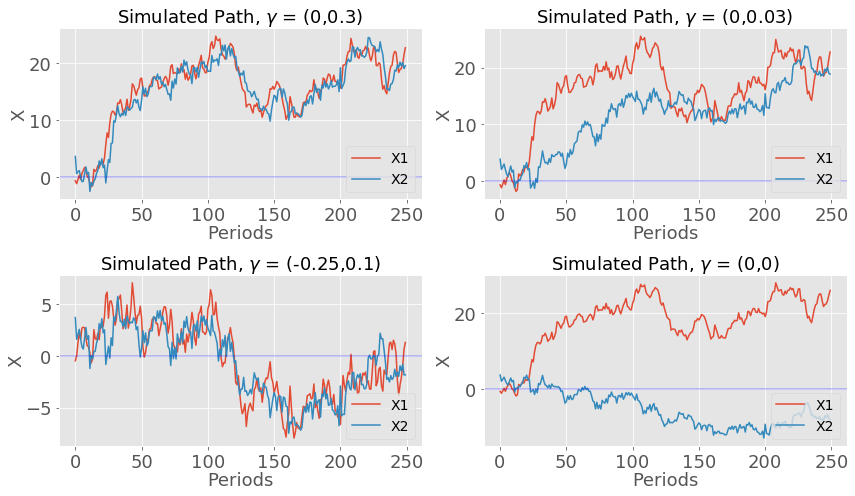

In [5]:
f,a = plt.subplots(figsize=(12,7))

T = 250
for i in range(1,5):
    a = plt.subplot(2,2,i)
    for j in range(2):
        a.plot(np.arange(T), X[T,i][:,j], label = "X"+str(j+1))
    a.set_xlabel('Periods', fontsize=18)
    a.set_ylabel('X', fontsize=18)
    a.set_title('Simulated Path, $\gamma$ = (' + str(gamma[i][0]) + ','+ str(gamma[i][1]) + ')', fontsize=18)
    a.axhline(y=0, linewidth=0.4)
    a.legend(loc='lower right', ncol=1)
f.tight_layout()
plt.show()
filename = 'output/figures/sample_x1x2_T250.pdf'
#f.savefig(filename,format='pdf')

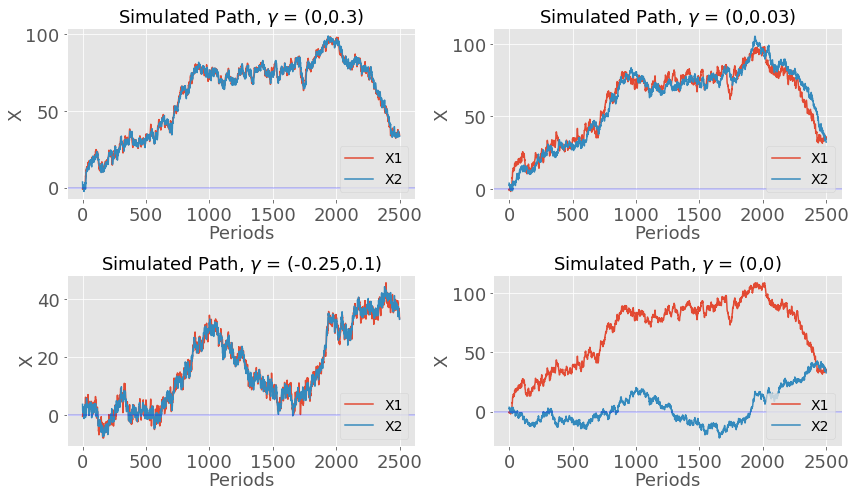

In [6]:
f,a = plt.subplots(figsize=(12,7))

T = 2500
for i in range(1,5):
    a = plt.subplot(2,2,i)
    for j in range(2):
        a.plot(np.arange(T), X[T,i][:,j], label = "X"+str(j+1))
    a.set_xlabel('Periods', fontsize=18)
    a.set_ylabel('X', fontsize=18)
    a.set_title('Simulated Path, $\gamma$ = (' + str(gamma[i][0]) + ','+ str(gamma[i][1]) + ')', fontsize=18)
    a.axhline(y=0, linewidth=0.4)
    a.legend(loc='lower right', ncol=1)
f.tight_layout()
plt.show()
filename = 'output/figures/sample_x1x2_T2500.pdf'
#f.savefig(filename,format='pdf')

(a)

In [7]:
vecm_models  = {}
vecm_estims  = {}
varx_models  = {}
varx_pstars  = {}
varx_estims  = {}
vardx_models = {}
vardx_pstars = {}
vardx_estims = {}

In [8]:
### Estimate VECM, VAR(X), VAR(Delta X)
# Note: we use statsmodel here, but you can/should of course code the procedures manually
# Some details on those are provided in lab4_2020 and lab5_2020
for T in {250,2500}:
    for i in range(1,5): # Loops from 1 to 4 includes
        
        ### VECM, including estimating alpha, statsmodel
        vecm_models[T,i] = VECM(X[T,i], k_ar_diff=1, coint_rank=1, deterministic='co')
        vecm_estims[T,i] = vecm_models[T,i].fit()
        
        ### VAR(X)
        #from statsmodels.tsa.vector_ar.var_model import VAR, VARProcess, VARResults
        #from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_order
        # Select lags
        varx_models[T,i] = VAR(X[T,i])
        varx_pstars[T,i]  =  varx_models[T,i].select_order().bic
        
        # Estimate
        varx_estims[T,i] = varx_models[T,i].fit(maxlags=varx_pstars[T,i])

        ### VAR(DeltaX)
        # Select lags
        vardx_models[T,i] = VAR(X[T,i][1:,:] - X[T,i][:-1,:])
        vardx_pstars[T,i] =  vardx_models[T,i].select_order().bic
        
        # Estimate
        vardx_estims[T,i] = vardx_models[T,i].fit(maxlags=vardx_pstars[T,i])

(b)

In [9]:
# Number of lags selected by BIC
print(varx_pstars)
print(vardx_pstars)

{(250, 1): 2, (250, 2): 2, (250, 3): 2, (250, 4): 2, (2500, 1): 2, (2500, 2): 2, (2500, 3): 2, (2500, 4): 2}
{(250, 1): 2, (250, 2): 1, (250, 3): 1, (250, 4): 1, (2500, 1): 6, (2500, 2): 1, (2500, 3): 6, (2500, 4): 1}


In [10]:
### Output estimated coefficients
for T in {250,2500}:
    for i in range(1,5): # Loops from 1 to 4 includes
        print('----- T={}, gamma{}=({},{}), Phi=(({},{}),({},{})), Psi1=(({},{}),({},{})), Psi2=(({},{}),({},{}))'\
              .format(T,i,gamma[i][0],gamma[i][1],
                      phi11,phi12,phi21,phi22,
                      Psi1[T,i][0,0],Psi1[T,i][0,1],Psi1[T,i][1,0],np.round(Psi1[T,i][1,1],2),
                      Psi2[T,i][0,0],Psi2[T,i][0,1],Psi2[T,i][1,0],Psi2[T,i][1,1]))
        print('VECM         coefs:  gamma hat=({},{}), alpha hat=({},{}), Phi1 hat = (({},{}),({},{}))'\
              .format(np.round(vecm_estims[T,i].alpha[0][0],2),np.round(vecm_estims[T,i].alpha[1][0],2),
                      np.round(vecm_estims[T,i].beta[0][0],2),np.round(vecm_estims[T,i].beta[1][0],2),
                      np.round(vecm_estims[T,i].gamma[0,0],2),np.round(vecm_estims[T,i].gamma[0,1],2),
                      np.round(vecm_estims[T,i].gamma[1,0],2),np.round(vecm_estims[T,i].gamma[1,1],2)))
        print('             stds:   gamma hat=({},{}), alpha hat=({},{}), Phi1 hat = (({},{}),({},{}))'\
              .format(np.round(vecm_estims[T,i].stderr_alpha[0][0],2),np.round(vecm_estims[T,i].stderr_alpha[1][0],2),
                      np.round(vecm_estims[T,i].stderr_beta[0][0],2),np.round(vecm_estims[T,i].stderr_beta[1][0],2),
                      np.round(vecm_estims[T,i].stderr_gamma[0,0],2),np.round(vecm_estims[T,i].stderr_gamma[0,1],2),
                      np.round(vecm_estims[T,i].stderr_gamma[1,0],2),np.round(vecm_estims[T,i].stderr_gamma[1,1],2)))
        print('             p-vals: gamma hat=({},{}), alpha hat=({},{}), Phi1 hat = (({},{}),({},{}))'\
              .format(np.round(vecm_estims[T,i].pvalues_alpha[0][0],2),np.round(vecm_estims[T,i].pvalues_alpha[1][0],2),
                      np.round(vecm_estims[T,i].pvalues_beta[0][0],2),np.round(vecm_estims[T,i].pvalues_beta[1][0],2),
                      np.round(vecm_estims[T,i].pvalues_gamma[0,0],2),np.round(vecm_estims[T,i].pvalues_gamma[0,1],2),
                      np.round(vecm_estims[T,i].pvalues_gamma[1,0],2),np.round(vecm_estims[T,i].pvalues_gamma[1,1],2)))
        print('VAR(X)       coefs:  Psi1 hat=(({},{}),({},{})), Psi2 hat=(({},{}),({},{}))'\
              .format(np.round(varx_estims[T,i].coefs[0][0,0],2),np.round(varx_estims[T,i].coefs[0][0,1],2),
                     np.round(varx_estims[T,i].coefs[0][1,0],2),np.round(varx_estims[T,i].coefs[0][1,1],2),
                     np.round(varx_estims[T,i].coefs[1][0,0],2),np.round(varx_estims[T,i].coefs[1][0,1],2),
                     np.round(varx_estims[T,i].coefs[1][1,0],2),np.round(varx_estims[T,i].coefs[1][1,1],2)))
        print('             stds:   Psi1 hat=(({},{}),({},{})), Psi2 hat=(({},{}),({},{}))'\
              .format(np.round(varx_estims[T,i].stderr[1][0],2),np.round(varx_estims[T,i].stderr[2][0],2),
                     np.round(varx_estims[T,i].stderr[1][1],2),np.round(varx_estims[T,i].stderr[2][1],2),
                     np.round(varx_estims[T,i].stderr[3][0],2),np.round(varx_estims[T,i].stderr[4][0],2),
                     np.round(varx_estims[T,i].stderr[3][1],2),np.round(varx_estims[T,i].stderr[4][1],2)))
        print('             p-vals: Psi1 hat=(({},{}),({},{})), Psi2 hat=(({},{}),({},{}))'\
              .format(np.round(varx_estims[T,i].pvalues[1][0],2),np.round(varx_estims[T,i].pvalues[2][0],2),
                     np.round(varx_estims[T,i].pvalues[1][1],2),np.round(varx_estims[T,i].pvalues[2][1],2),
                     np.round(varx_estims[T,i].pvalues[3][0],2),np.round(varx_estims[T,i].pvalues[4][0],2),
                     np.round(varx_estims[T,i].pvalues[3][1],2),np.round(varx_estims[T,i].pvalues[4][1],2)))
        print('VAR(Delta X) coefs:  Phi1 hat=(({},{}),({},{}))'\
              .format(np.round(vardx_estims[T,i].coefs[0][0,0],2),np.round(vardx_estims[T,i].coefs[0][0,1],2),
                     np.round(vardx_estims[T,i].coefs[0][1,0],2),np.round(vardx_estims[T,i].coefs[0][1,1],2)))
        print('             stds:   Phi1 hat=(({},{}),({},{}))'\
              .format(np.round(vardx_estims[T,i].stderr[1][0],2),np.round(vardx_estims[T,i].stderr[2][0],2),
                     np.round(vardx_estims[T,i].stderr[1][1],2),np.round(vardx_estims[T,i].stderr[2][1],2)))
        print('             p-vals: Phi1 hat=(({},{}),({},{}))'\
              .format(np.round(vardx_estims[T,i].pvalues[1][0],2),np.round(vardx_estims[T,i].pvalues[2][0],2),
                     np.round(vardx_estims[T,i].pvalues[1][1],2),np.round(vardx_estims[T,i].pvalues[2][1],2)))
        print('\n')

----- T=250, gamma1=(0,0.3), Phi=((0.2,-0.1),(0,-0.25)), Psi1=((1.2,-0.1),(0.3,0.45)), Psi2=((-0.2,0.1),(0.0,0.25))
VECM         coefs:  gamma hat=(0.01,0.35), alpha hat=(1.0,-1.0), Phi1 hat = ((0.15,-0.21),(-0.06,-0.3))
             stds:   gamma hat=(0.04,0.03), alpha hat=(0.0,0.03), Phi1 hat = ((0.07,0.05),(0.07,0.05))
             p-vals: gamma hat=(0.76,0.0), alpha hat=(0.0,0.0), Phi1 hat = ((0.04,0.0),(0.37,0.0))
VAR(X)       coefs:  Psi1 hat=((1.14,-0.22),(0.29,0.35)), Psi2 hat=((-0.14,0.2),(0.06,0.3))
             stds:   Psi1 hat=((0.06,0.06),(0.06,0.06)), Psi2 hat=((0.07,0.05),(0.07,0.05))
             p-vals: Psi1 hat=((0.0,0.0),(0.0,0.0)), Psi2 hat=((0.05,0.0),(0.38,0.0))
VAR(Delta X) coefs:  Phi1 hat=((0.17,-0.21),(0.33,-0.33))
             stds:   Phi1 hat=((0.06,0.06),(0.07,0.06))
             p-vals: Phi1 hat=((0.01,0.0),(0.0,0.0))


----- T=250, gamma2=(0,0.03), Phi=((0.2,-0.1),(0,-0.25)), Psi1=((1.2,-0.1),(0.03,0.72)), Psi2=((-0.2,0.1),(0.0,0.25))
VECM         coefs: 

In [11]:
### Checking the restrictions
for T in {250,2500}:
    for i in range(1,5): # Loops from 1 to 4 includes
        print('T={}, gamma{}=({},{}): sum row 1={}, sum row2={}'.format(
            T,i,gamma[i][0],gamma[i][1],
            np.round(np.sum(varx_estims[T,i].coefs[0][0,:]+varx_estims[T,i].coefs[1][0,:]),3),
            np.round(np.sum(varx_estims[T,i].coefs[0][1,:]+varx_estims[T,i].coefs[1][1,:]),3)))

T=250, gamma1=(0,0.3): sum row 1=0.973, sum row2=1.003
T=250, gamma2=(0,0.03): sum row 1=0.974, sum row2=0.999
T=250, gamma3=(-0.25,0.1): sum row 1=1.007, sum row2=0.965
T=250, gamma4=(0,0): sum row 1=0.977, sum row2=0.969
T=2500, gamma1=(0,0.3): sum row 1=0.998, sum row2=1.001
T=2500, gamma2=(0,0.03): sum row 1=0.998, sum row2=1.001
T=2500, gamma3=(-0.25,0.1): sum row 1=0.995, sum row2=1.0
T=2500, gamma4=(0,0): sum row 1=0.995, sum row2=1.0


(c) Long-horizon regressions

In [11]:
def lh_reg(x, z, k):
    ### k-horizon difference
    Dx_k =(np.roll(x, -k) - x)[:-k]
    Z = sm.add_constant( z[:-k] )
    ols_fit = sm.OLS(Dx_k, Z).fit()
    
    ### point estimate
    beta_hat = ols_fit.params[-1]
    
    ### SEs:
    # 1. Robust
    se_r = ols_fit.get_robustcov_results(cov_type='HC0').bse[-1]
    
    # 2. Newey-West
    se_nw = ols_fit.get_robustcov_results(cov_type='HAC', maxlags=k).bse[-1]
    
    # 3a. Hansen-Hodrick
    u = ols_fit.resid
    D = np.dot(Z.T, Z) / Z.shape[0]
    Zu = Z * u[:,None]
    #--> sum up S
    S = np.dot(Zu.T, Zu) / Zu.shape[0]
    for j in range(1, k):
        Zu_j = Zu[:-j, :]
        Zu_j_lag = Zu[j:, :]
        Sj = np.dot(Zu_j.T, Zu_j_lag) / Zu_j.shape[0]
        S += Sj + Sj.T
    #--> Variance-covariance matrix
    Dtinv  = np.linalg.inv(D.T)
    Dinv   = np.linalg.inv(D)
    HH_cov = np.dot(np.dot(Dtinv, S), Dinv) / Z.shape[0]
    se_hh1 = np.sqrt(HH_cov[-1,-1])
    
    # 3b. Hansen-Hodrick (statsmodels) (HAC with 'kernel'= 'uniform', and 'maxlags'=k)
    se_hh2 = ols_fit.get_robustcov_results(cov_type='HAC', maxlags=k, kernel='uniform').bse[-1]
    
    r2 = ols_fit.rsquared
    return (beta_hat, se_r, se_nw, se_hh1, se_hh2, r2, u)

def long_horizon_regs(x, z, k_horizon=10,print_table=True):
    lh_table = np.empty((k_horizon, 7))
    for k in range(k_horizon):
        lh_table[k,0] = k+1
        (beta_hat, se_r, se_nw, se_hh1, se_hh2, r2, _) = lh_reg(x, z, k+1)
        lh_table[k,1] = beta_hat
        lh_table[k,2] = se_r
        lh_table[k,3] = se_nw
        lh_table[k,4] = se_hh1
        lh_table[k,5] = se_hh2
        lh_table[k,6] = r2
    if print_table==True:
        headers = ['Horizon k', 'Est: beta_k', 'SE(r)', 'SE(nw)', 'SE(hh1)', 'SE(hh2)', 'R2']
        tbl = sm.iolib.table.SimpleTable(lh_table, headers,
                data_fmts=['%d', '%0.2f', '%0.2f', '%0.2f', '%0.2f', '%0.2f',' %0.2f'] )
        print(tbl, '\n\n\n')
    return lh_table

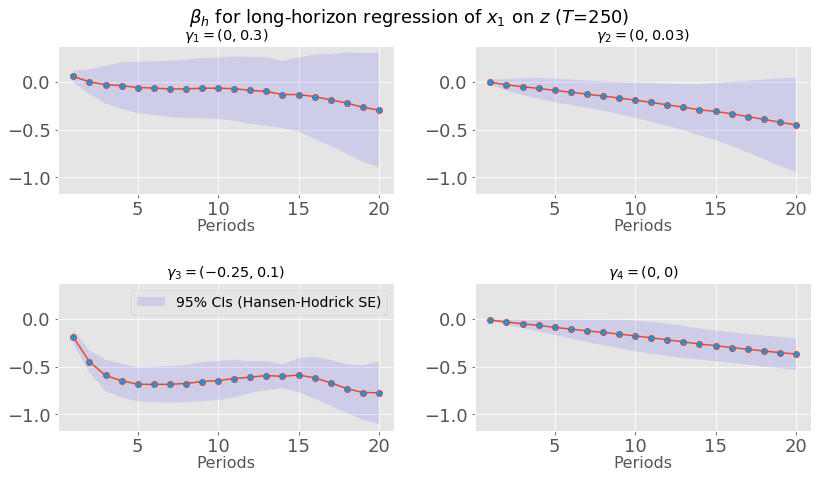

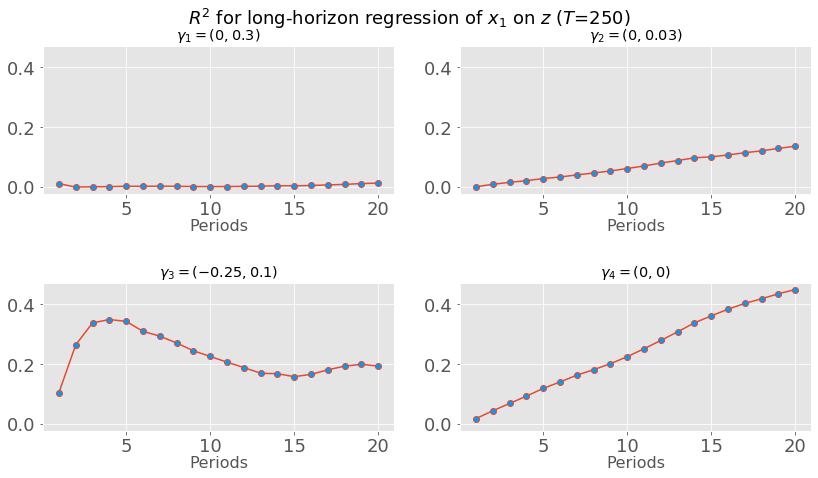

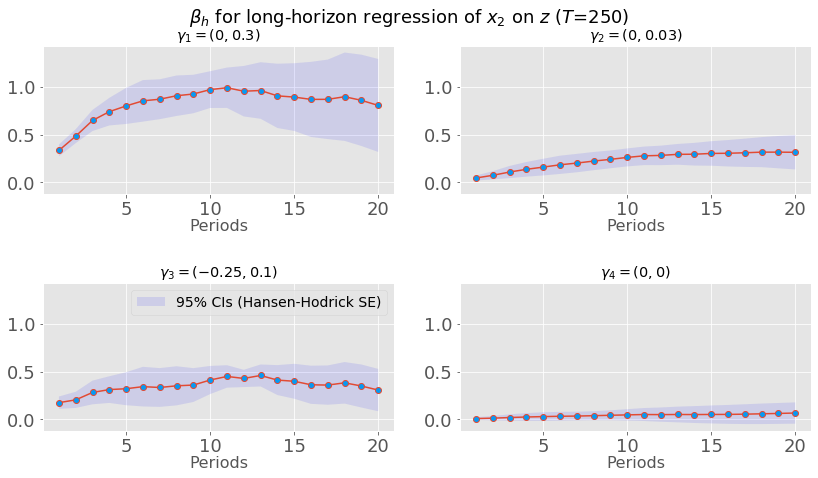

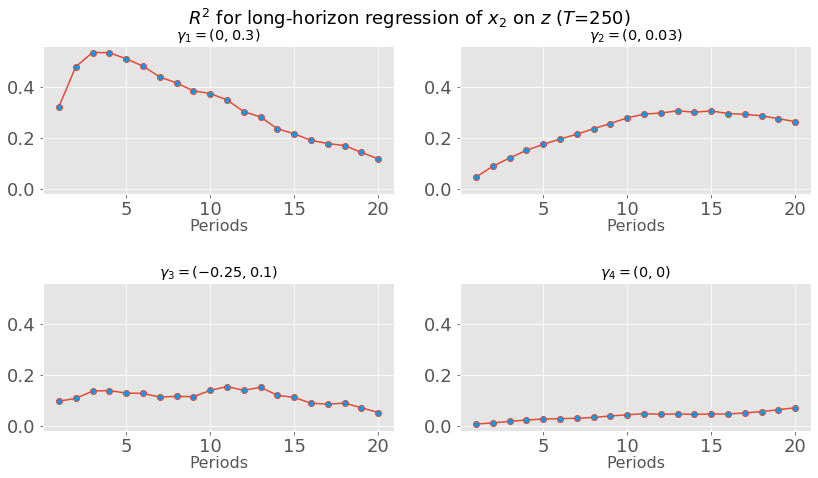

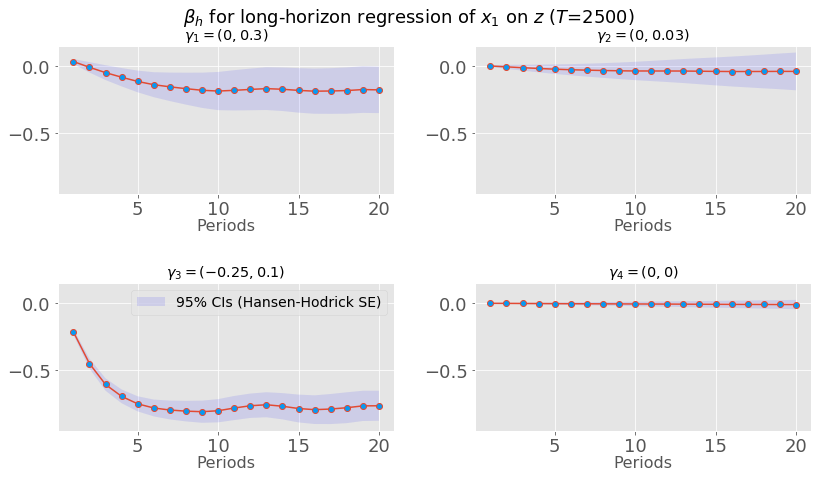

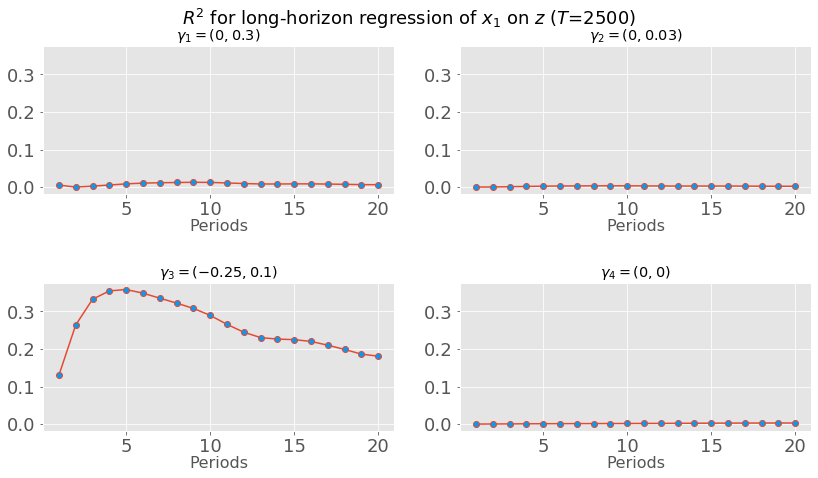

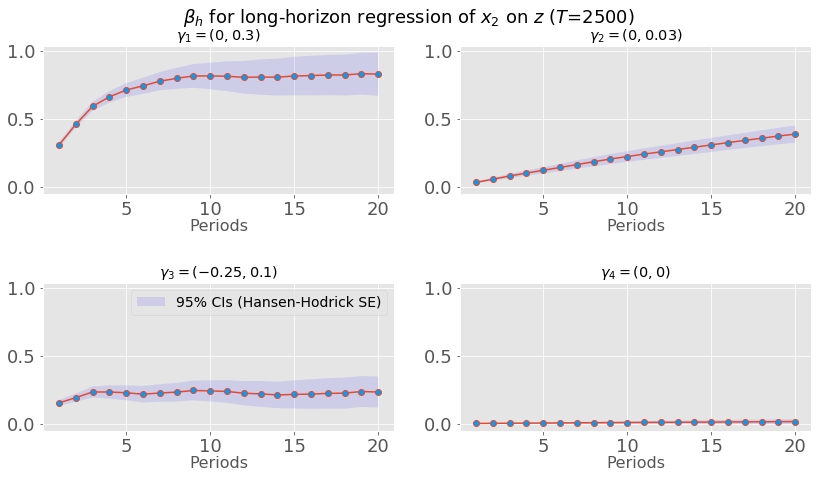

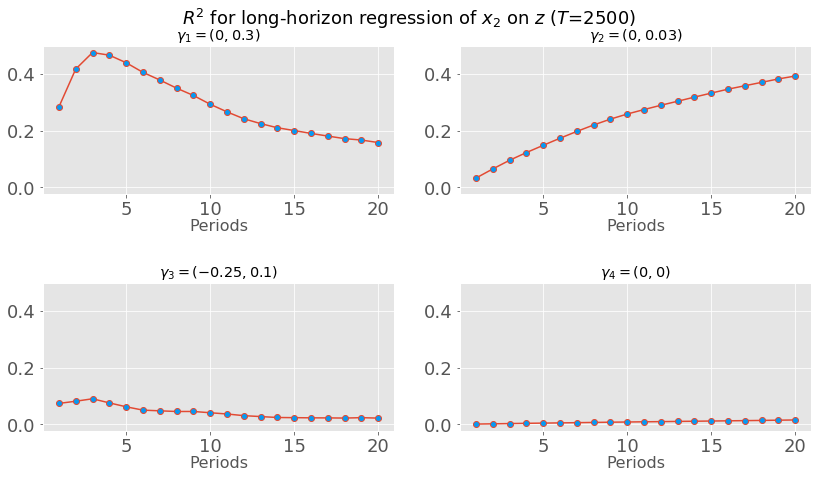

In [12]:
### Long-horizon regressions graphs
# Note: could be made into a function
for T in {250,2500}:
    # j = 0 is x1, j = 1 is x2
    for j in range(2):
        # beta_h plot
        f, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(12,7))
        for i in range(1,5): # Loops from 1 to 4 includes
            lhreg_table = long_horizon_regs(X[T,i][:,j],X[T,i][:,0]-X[T,i][:,1],k_horizon=20,print_table=False)
            #a = plt.subplot(2,2,i)
            a = ax[(i-1)//2,(i-1)%2] #sharey=True does not work with above
            a.plot(lhreg_table[:,0], lhreg_table[:,1], marker='o', markerfacecolor='xkcd:azure')
            a.fill_between(x=lhreg_table[:,0], 
                                 y1=lhreg_table[:,1] - 1.96*lhreg_table[:,4], 
                                 y2=lhreg_table[:,1] + 1.96*lhreg_table[:,4], 
                                 facecolor='blue', alpha=0.1, label='95% CIs (Hansen-Hodrick SE)')
            a.set_xlabel('Periods', fontsize=16)
            if i == 3:
                a.legend(fontsize=14, loc='best')
            a.yaxis.set_tick_params(labelbottom=True)
            a.title.set_text(r'$\gamma_{}=({},{})$'.format(i,gamma[i][0],gamma[i][1]))
        f.suptitle(r'$\beta_h$ for long-horizon regression of $x_{}$ on $z$ ($T$={})'.format(j+1,T), fontsize=18)
        f.tight_layout(pad=3.0)
        plt.show()
        filename = 'output/figures/lhr_betah_x' + str(j+1) + '_T' + str(T) + '.pdf'
        #f.savefig(filename,format='pdf')

        # R2 plot
        f, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(12,7))
        for i in range(1,5): # Loops from 1 to 4 includes
            lhreg_table = long_horizon_regs(X[T,i][:,j],X[T,i][:,0]-X[T,i][:,1],k_horizon=20,print_table=False)
            #a = plt.subplot(2,2,i)
            a = ax[(i-1)//2,(i-1)%2] #sharey=True does not work with above
            a.plot(lhreg_table[:,0], lhreg_table[:,6], marker='o', markerfacecolor='xkcd:azure')
            a.set_xlabel('Periods', fontsize=16)
            a.yaxis.set_tick_params(labelbottom=True)
            a.title.set_text(r'$\gamma_{}=({},{})$'.format(i,gamma[i][0],gamma[i][1]))
        f.suptitle(r'$R^2$ for long-horizon regression of $x_{}$ on $z$ ($T$={})'.format(j+1,T), fontsize=18)
        f.tight_layout(pad=3.0)
        plt.show()
        filename = 'output/figures/lhr_R2_x' + str(j+1) + '_T' + str(T) + '.pdf'
        #f.savefig(filename,format='pdf')

In [13]:
# Long-horizon regression for x1
for T in {250,2500}:
    for i in range(1,5): # Loops from 1 to 4 includes
        print('----- T={}, gamma{}=({},{})'.format(T,i,gamma[i][0],gamma[i][1]))
        _ = long_horizon_regs(X[T,i][:,0],X[T,i][:,0]-X[T,i][:,1],k_horizon=20)

----- T=250, gamma1=(0,0.3)
Horizon k Est: beta_k SE(r) SE(nw) SE(hh1) SE(hh2)   R2 
--------------------------------------------------------
        1        0.05  0.03   0.03    0.03    0.03  0.01
        2       -0.00  0.05   0.06    0.07    0.07  0.00
        3       -0.03  0.06   0.09    0.10    0.10  0.00
        4       -0.04  0.07   0.11    0.12    0.12  0.00
        5       -0.06  0.08   0.12    0.14    0.13  0.00
        6       -0.07  0.08   0.13    0.14    0.14  0.00
        7       -0.08  0.09   0.14    0.15    0.15  0.00
        8       -0.08  0.10   0.15    0.16    0.15  0.00
        9       -0.07  0.10   0.16    0.16    0.16  0.00
       10       -0.07  0.10   0.16    0.16    0.16  0.00
       11       -0.07  0.10   0.17    0.17    0.17  0.00
       12       -0.09  0.10   0.17    0.18    0.18  0.00
       13       -0.10  0.11   0.17    0.18    0.18  0.00
       14       -0.13  0.11   0.17    0.18    0.18  0.00
       15       -0.13  0.11   0.18    0.20    0.20  0.00
   

In [14]:
# Long-horizon regression for x2
for T in {250,2500}:
    for i in range(1,5): # Loops from 1 to 4 includes
        print('----- T={}, gamma{}=({},{})'.format(T,i,gamma[i][0],gamma[i][1]))
        _ = long_horizon_regs(X[T,i][:,1],X[T,i][:,0]-X[T,i][:,1],k_horizon=20)

----- T=250, gamma1=(0,0.3)
Horizon k Est: beta_k SE(r) SE(nw) SE(hh1) SE(hh2)   R2 
--------------------------------------------------------
        1        0.33  0.03   0.03    0.03    0.03  0.32
        2        0.48  0.03   0.04    0.04    0.04  0.48
        3        0.65  0.04   0.05    0.06    0.06  0.53
        4        0.74  0.05   0.07    0.07    0.07  0.53
        5        0.80  0.06   0.09    0.10    0.09  0.51
        6        0.85  0.07   0.10    0.11    0.11  0.48
        7        0.87  0.07   0.10    0.11    0.10  0.44
        8        0.91  0.07   0.11    0.11    0.11  0.42
        9        0.92  0.08   0.11    0.10    0.10  0.38
       10        0.97  0.07   0.10    0.10    0.10  0.37
       11        0.99  0.08   0.11    0.11    0.11  0.35
       12        0.95  0.09   0.14    0.13    0.13  0.30
       13        0.96  0.09   0.15    0.15    0.15  0.28
       14        0.90  0.10   0.17    0.17    0.17  0.24
       15        0.89  0.10   0.17    0.18    0.18  0.22
   

## Problem 5

In [15]:
### Loading the data
df = pd.read_csv("MFE230E_PS4_data.csv")
df = df.rename(columns={'Unnamed: 0': 'year'})
df['p'] = np.log(df['P'])
df['e'] = np.log(df['E'])

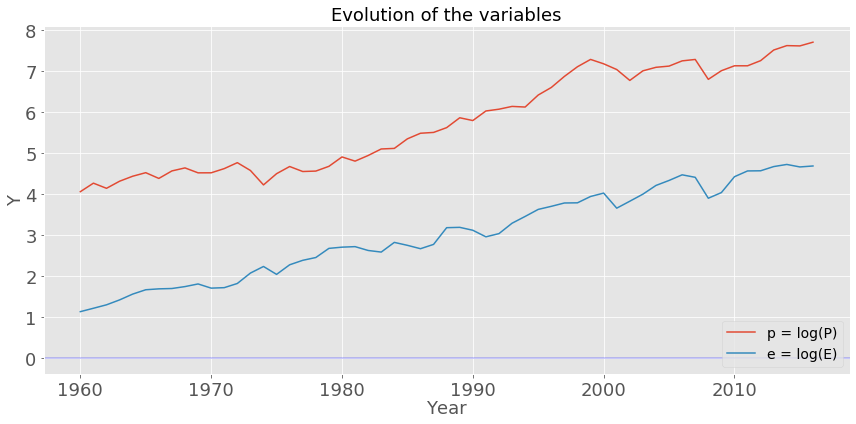

In [16]:
f,a = plt.subplots(figsize=(12,6))

a.plot(pd.to_datetime(df['year']).dt.year, df['p'],label='p = log(P)')
a.plot(pd.to_datetime(df['year']).dt.year, df['e'],label='e = log(E)')
a.set_xlabel('Year', fontsize=18)
a.set_ylabel('Y', fontsize=18)
a.set_title('Evolution of the variables', fontsize=18)
a.axhline(y=0, linewidth=0.4)
a.legend(loc='lower right', ncol=1)

f.tight_layout()
plt.show()
filename = 'output/figures/Q5b_p_and_e.pdf'
#f.savefig(filename,format='pdf')

(a)

In [17]:
### Test whether log prices and log earnings are stationary
def ADF_test(df): 
    for j in range(0, df.shape[1]):
        adf_result1 = sm.tsa.stattools.adfuller(df.iloc[:,j])
        print('\tY'+str(j)+': ADF statistic (p-value): %0.3f (%0.3f)' % (adf_result1[0], adf_result1[1]),
                      '\n\tcritical values', adf_result1[4],'\n')

In [18]:
print("ADF test:")
ADF_test(df[['p','e']])
print("ADF test first diff:")
ADF_test(df[['p','e']].diff().dropna())

ADF test:
	Y0: ADF statistic (p-value): -0.227 (0.935) 
	critical values {'1%': -3.552928203580539, '5%': -2.9147306250000002, '10%': -2.595137155612245} 

	Y1: ADF statistic (p-value): -0.279 (0.928) 
	critical values {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616} 

ADF test first diff:
	Y0: ADF statistic (p-value): -7.610 (0.000) 
	critical values {'1%': -3.5552728880540942, '5%': -2.9157312396694217, '10%': -2.5956695041322315} 

	Y1: ADF statistic (p-value): -5.454 (0.000) 
	critical values {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616} 



(b)

In [19]:
### Stationarity of p-e
df['pe'] = df['p']-df['e']
adf_resul_pe = sm.tsa.stattools.adfuller(df['pe'],regression='c')
print('pe: ADF statistic (p-value): %0.3f (%0.3f)' % (adf_resul_pe[0], adf_resul_pe[1]),
              '\ncritical values', adf_resul_pe[4],'\n')

adf_resul_pe = sm.tsa.stattools.adfuller(df['pe'],regression='ct')
print('pe: ADF statistic (p-value): %0.3f (%0.3f)' % (adf_resul_pe[0], adf_resul_pe[1]),
              '\ncritical values', adf_resul_pe[4],'\n')

adf_resul_pe = sm.tsa.stattools.adfuller(df['pe'],regression='ctt')
print('pe: ADF statistic (p-value): %0.3f (%0.3f)' % (adf_resul_pe[0], adf_resul_pe[1]),
              '\ncritical values', adf_resul_pe[4],'\n')

adf_resul_pe = sm.tsa.stattools.adfuller(df['pe'],regression='nc')
print('pe: ADF statistic (p-value): %0.3f (%0.3f)' % (adf_resul_pe[0], adf_resul_pe[1]),
              '\ncritical values', adf_resul_pe[4],'\n')

pe: ADF statistic (p-value): -2.361 (0.153) 
critical values {'1%': -3.552928203580539, '5%': -2.9147306250000002, '10%': -2.595137155612245} 

pe: ADF statistic (p-value): -2.622 (0.270) 
critical values {'1%': -4.130261462053571, '5%': -3.4920297480867344, '10%': -3.1746004600947524} 

pe: ADF statistic (p-value): -2.620 (0.500) 
critical values {'1%': -4.591386162308673, '5%': -3.9425052469023325, '10%': -3.620659739203717} 

pe: ADF statistic (p-value): -0.200 (0.614) 
critical values {'1%': -2.606821568877551, '5%': -1.9466916602131925, '10%': -1.612798147776968} 



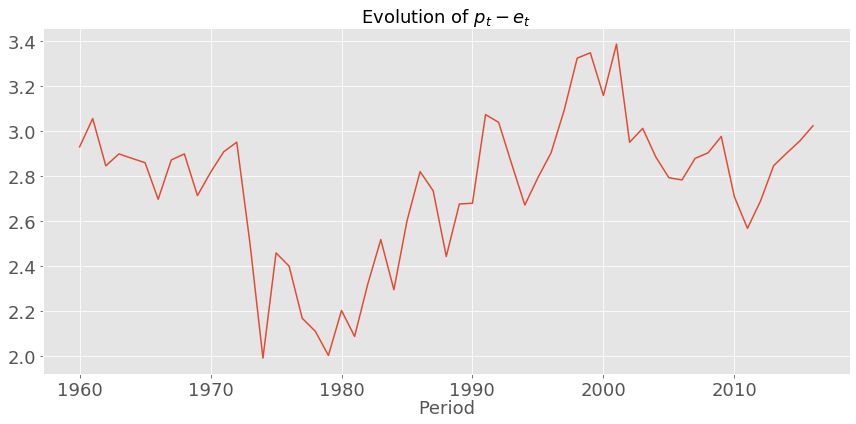

In [20]:
Y = df['pe'].values
T = pd.to_datetime(df['year']).dt.year
f,a = plt.subplots(figsize=(12,6))
a.plot(T, Y)
a.set_xlabel('Period', fontsize=18)
a.set_title('Evolution of $p_t-e_t$', fontsize=18)
f.tight_layout()
filename = 'output/figures/Q5b_pe.pdf'
#f.savefig(filename,format='pdf')

(c)

In [21]:
### VECM estimation
vecm_model_pe = VECM(df[['p','e']], k_ar_diff=1, coint_rank=1, deterministic='co')
vecm_estim_pe =vecm_model_pe.fit()

In [22]:
vecm_estim_pe.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
const,0.3519,0.142,2.471,0.013,0.073,0.631
L1.p,0.0019,0.134,0.014,0.989,-0.260,0.264
L1.e,-0.0181,0.144,-0.126,0.900,-0.299,0.263
,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.1734,0.136,-1.272,0.203,-0.441,0.094
L1.p,0.1160,0.128,0.907,0.364,-0.135,0.367
L1.e,0.0973,0.137,0.709,0.479,-0.172,0.367
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.1351,0.065,-2.065,0.039,-0.263,-0.007
,coef,std err,z,P>|z|,[0.025,0.975]


In [23]:
print(vecm_estim_pe.summary().as_latex())

\begin{center}
\begin{tabular}{lcccccc}
\toprule
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}  &       0.3519  &        0.142     &     2.471  &         0.013        &        0.073    &        0.631     \\
\textbf{L1.p}   &       0.0019  &        0.134     &     0.014  &         0.989        &       -0.260    &        0.264     \\
               & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const} &      -0.1734  &        0.136     &    -1.272  &         0.203        &       -0.441    &        0.094     \\
\textbf{L1.p}  &       0.1160  &        0.128     &     0.907  &         0.364        &       -0.135    &        0.367     \\
\textbf{L1.e}  &       0.0973  &        0.137     &     0.709  &         0.479        &       -0.172    &        0.367     \\
             & \textbf{coef} & \textbf{std err} & 

(d)

In [24]:
def lh_reg(x, z, k):
    ### k-horizon difference
    Dx_k =(np.roll(x, -k) - x)[:-k]
    Z = sm.add_constant( z[:-k] )
    ols_fit = sm.OLS(Dx_k, Z).fit()
    
    ### point estimate
    beta_hat = ols_fit.params[-1]
    
    ### SEs:
    
    # 1. Robust
    se_r = ols_fit.get_robustcov_results(cov_type='HC0').bse[-1]
    
    # 2. Newey-West
    se_nw = ols_fit.get_robustcov_results(cov_type='HAC', maxlags=k).bse[-1]
    
    # 3a. Hansen-Hodrick
    u = ols_fit.resid
    D = np.dot(Z.T, Z) / Z.shape[0]
    Zu = Z * u[:,None]
    #--> sum up S
    S = np.dot(Zu.T, Zu) / Zu.shape[0]
    for j in range(1, k):
        Zu_j = Zu[:-j, :]
        Zu_j_lag = Zu[j:, :]
        Sj = np.dot(Zu_j.T, Zu_j_lag) / Zu_j.shape[0]
        S += Sj + Sj.T
    #--> Variance-covariance matrix
    Dtinv  = np.linalg.inv(D.T)
    Dinv   = np.linalg.inv(D)
    HH_cov = np.dot(np.dot(Dtinv, S), Dinv) / Z.shape[0]
    se_hh1 = np.sqrt(HH_cov[-1,-1])
    
    # 3b. Hansen-Hodrick (statsmodels) (HAC with 'kernel'= 'uniform', and 'maxlags'=k)
    se_hh2 = ols_fit.get_robustcov_results(cov_type='HAC', maxlags=k, kernel='uniform').bse[-1]
    
    r2 = ols_fit.rsquared
    return (beta_hat, se_r, se_nw, se_hh1, se_hh2, r2, u)

def long_horizon_regs(x, z, k_horizon=10,print_table=True):
    lh_table = np.empty((k_horizon, 7))
    for k in range(k_horizon):
        lh_table[k,0] = k+1
        (beta_hat, se_r, se_nw, se_hh1, se_hh2, r2, _) = lh_reg(x, z, k+1)
        lh_table[k,1] = beta_hat
        lh_table[k,2] = se_r
        lh_table[k,3] = se_nw
        lh_table[k,4] = se_hh1
        lh_table[k,5] = se_hh2
        lh_table[k,6] = r2
    if print_table==True:
        headers = ['Horizon k', 'Est: beta_k', 'SE(white)', 'SE(nw)', 'SE(hh1)', 'SE(hh2)', 'R2']
        tbl = sm.iolib.table.SimpleTable(lh_table, headers,
                data_fmts=['%d', '%0.2f', '%0.2f', '%0.2f', '%0.2f', '%0.2f',' %0.2f'] )
        print(tbl, '\n\n\n')
    return lh_table

In [25]:
print('Long-horizon regression for p')
_ = long_horizon_regs(df['p'].values,df['pe'].values,k_horizon=5)

print('Long-horizon regression for e')
_ = long_horizon_regs(df['e'].values,df['pe'].values,k_horizon=5)

Long-horizon regression for p
Horizon k Est: beta_k SE(white) SE(nw) SE(hh1) SE(hh2)   R2 
------------------------------------------------------------
        1       -0.12      0.06   0.06    0.06    0.06  0.05
        2       -0.22      0.07   0.08    0.09    0.08  0.10
        3       -0.28      0.08   0.10    0.11    0.09  0.12
        4       -0.31      0.09   0.11    0.12    0.11  0.12
        5       -0.38      0.09   0.11    0.12    0.11  0.14
------------------------------------------------------------ 



Long-horizon regression for e
Horizon k Est: beta_k SE(white) SE(nw) SE(hh1) SE(hh2)   R2 
------------------------------------------------------------
        1        0.07      0.06   0.06    0.06    0.05  0.02
        2        0.12      0.09   0.10    0.11    0.10  0.03
        3        0.14      0.10   0.12    0.13    0.11  0.04
        4        0.17      0.10   0.12    0.12    0.09  0.05
        5        0.17      0.09   0.10    0.08    0.05  0.06
---------------------